<a href="https://colab.research.google.com/github/akpanitorobong/7135CEM-Modelling_and_Optimization_Under_Uncertainty/blob/main/7135_CEM_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Libraries**

In [2]:
print("Installing Libraries...")

# Install necessary packages
!pip install ucimlrepo  # For dataset handling
!pip install imbalanced-learn  # For class balancing

# mport Required Libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Enhanced visualization
import time  # For tracking execution time

from ucimlrepo import fetch_ucirepo  # For dataset import

from imblearn.under_sampling import RandomUnderSampler# Class balancing

# Feature Scaling & Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Training & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("Libraries imported successfully!")

Installing Libraries...
Libraries imported successfully!


# **Load and Inspect Dataset**

In [3]:
# **Load and Inspect Dataset**
print("Loading dataset...")

# Fetch dataset from UCI Repository
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Extract features and target variables
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Combine for easy data handling
df = pd.concat([X, y], axis=1)
df.to_csv('diabetes_health_indicators.csv', index=False)

print("Dataset loaded successfully.")
print("\nDataset Info:\n")
df.info()
print("\nFirst 5 Rows:\n")
df.head()

Loading dataset...
Dataset loaded successfully.

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth            

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **Preprocessing**

In [4]:
# Remove unnecessary column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    print("Column 'Unnamed: 0' removed.")

# Check for and remove duplicate rows
no_of_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Number of duplicate rows removed: {no_of_duplicates}")

Number of duplicate rows removed: 24206


# **Class Balancing**

In [5]:
# Define target variable
target_col = "Diabetes_binary"
X = df.drop(columns=[target_col])  # Features
y = df[target_col]  # Target variable

# Check class distribution before balancing
print("\nClass Distribution Before Balancing:")
print(y.value_counts(), "\n")

# Apply Random Undersampling to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced[target_col] = y_resampled  # Add target column back

print("Dataset balanced using Random Undersampling. \nNew class distribution:")
print(df_balanced[target_col].value_counts())


Class Distribution Before Balancing:
Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64 

Dataset balanced using Random Undersampling. 
New class distribution:
Diabetes_binary
0    35097
1    35097
Name: count, dtype: int64


# **Standardization**

In [6]:
# Identify numerical columns (excluding categorical features)
num_cols = ["BMI", "MentHlth", "PhysHlth", "Age", "Education", "Income"]

# Standardize numerical features
scaler = StandardScaler()
df_balanced[num_cols] = scaler.fit_transform(df_balanced[num_cols])

print("Numerical features standardized.")
print("Rows affected: ", num_cols)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(columns=[target_col]),
                                                    df_balanced[target_col],
                                                    test_size=0.2,
                                                    random_state=42)

print("\nData split into training and testing sets.")

Numerical features standardized.
Rows affected:  ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Data split into training and testing sets.


# **Feature Importance**

**Get Top Features**

In [20]:
print("\nCalculating Feature Importance using Random Forest...")

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N features (e.g., 10)
top_features = feature_importance_df.iloc[:10]['Feature'].values
X_train_FI = X_train[top_features]
X_test_FI = X_test[top_features]

# Display top 10 features
print("\nTop 10 Most Important Features:\n")
print(feature_importance_df.head(10))


Calculating Feature Importance using Random Forest...

Top 10 Most Important Features:

      Feature  Importance
3         BMI    0.171804
18        Age    0.128894
13    GenHlth    0.091159
20     Income    0.087525
0      HighBP    0.072561
15   PhysHlth    0.071282
19  Education    0.061510
14   MentHlth    0.053762
1    HighChol    0.039219
4      Smoker    0.030037


**Visualization**

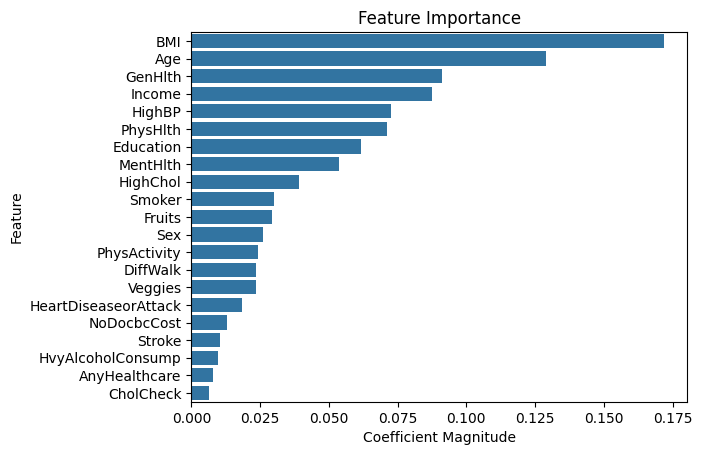

In [19]:
# Plot
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# **PCA on FI**

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_FI)
X_test_scaled = scaler.transform(X_test_FI)

# Apply PCA (you can specify n_components based on variance explained)
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
sum = 0
for i in explained_variance :
    sum= sum + i

print("Explained Variance Ratio:", explained_variance)
print("Variance sum:", sum)
print("Number of Components Selected:", pca.n_components_)

Explained Variance Ratio: [0.25887224 0.14098042 0.11527241 0.10151225 0.09041414 0.07649723
 0.06473804 0.05648534 0.05328981]
Variance sum: 0.9580618877837052
Number of Components Selected: 9


# **Train and Test Data**

**Apply PCA on Top 10 Features**

In [15]:
print("\nApplying PCA on Selected Features...")

# Standardize selected features before PCA
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Apply PCA
pca = PCA(n_components=9)  # Reduce to 9 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\nPCA applied on top 10 features. Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
sum = 0
for i in pca.explained_variance_ratio_ :
    sum= sum + i
print("Sum: ", sum)


Applying PCA on Selected Features...

PCA applied on top 10 features. Explained Variance Ratio:
[0.25887224 0.14098042 0.11527241 0.10151225 0.09041414 0.07649723
 0.06473804 0.05648534 0.05328981]
Sum:  0.9580618877837052


- # **PCA → Feature Importance Approach**

In [16]:
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% variance
num_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Number of components that explain at least 95% variance: {num_components}")

print("\nApplying PCA on Selected Features...")

# Standardize train and test features before PCA
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA using the optimal number of components
pca_selected = PCA(n_components=num_components)
X_train_pca = pca_selected.fit_transform(X_train_scaled)
X_test_pca = pca_selected.transform(X_test_scaled)

print("\nPCA applied using selected number of components. Explained Variance Ratio:")
print(pca_selected.explained_variance_ratio_)

# Train a Random Forest model on PCA-transformed data
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)

# Get feature importances for principal components
importances_pca = rf_pca.feature_importances_
pca_importance_df = pd.DataFrame({'Principal Component': range(1, num_components + 1), 'Importance': importances_pca})
pca_importance_df = pca_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance of Principal Components:\n")
print(pca_importance_df)

Number of components that explain at least 95% variance: 19

Applying PCA on Selected Features...

PCA applied using selected number of components. Explained Variance Ratio:
[0.16334443 0.08325259 0.06398825 0.05808511 0.05692768 0.05169699
 0.04911064 0.04566318 0.04467328 0.04163458 0.03955069 0.03799205
 0.03564244 0.03538412 0.03404829 0.03387745 0.03112358 0.02661878
 0.02439919]

Feature Importance of Principal Components:

    Principal Component  Importance
0                     1    0.194544
1                     2    0.073846
5                     6    0.063379
7                     8    0.049122
4                     5    0.045852
6                     7    0.044007
10                   11    0.043094
18                   19    0.042844
14                   15    0.042223
9                    10    0.042197
16                   17    0.041384
11                   12    0.040649
8                     9    0.040108
17                   18    0.039849
12                   13   

- # **Principal Component Analysis**

In [21]:
# Separate features and target variable
X = df.drop(columns=["Diabetes_binary"])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% variance
num_components = np.argmax(explained_variance >= 0.95) + 1

num_components, explained_variance

(np.int64(19),
 array([0.15618418, 0.240806  , 0.30561086, 0.36337361, 0.41973912,
        0.47192232, 0.52107227, 0.56674258, 0.61120655, 0.65344866,
        0.69276683, 0.7310842 , 0.76691273, 0.80236677, 0.83679763,
        0.8706871 , 0.90296327, 0.93003495, 0.95520181, 0.97924884,
        1.        ]))

# **Feature Selection**

In [24]:
# Apply PCA with the selected number of components (19)
pca_selected = PCA(n_components=19)
X_pca_selected = pca_selected.fit_transform(X_scaled)

# Convert back to a DataFrame with meaningful column names
pca_columns = [f"PC{i+1}" for i in range(19)]
df_pca = pd.DataFrame(X_pca_selected, columns=pca_columns)

# Save the transformed dataset
df_pca.to_csv("dataset_feature_selected.csv", index=False)

       HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
PC1  0.256765  0.192292   0.061235  0.159173  0.138586  0.175692   
PC2  0.321656  0.308213   0.228266 -0.023973  0.025871  0.119314   
PC3 -0.095092 -0.064954   0.062495 -0.090342 -0.181068  0.044603   
PC4 -0.010973 -0.006298   0.185613  0.402884 -0.236286 -0.140826   
PC5 -0.031584  0.059131  -0.162856 -0.131990  0.434083  0.142684   

     HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  \
PC1              0.226585     -0.227573 -0.074406 -0.108845  ...   
PC2              0.229844      0.084736  0.149007  0.114143  ...   
PC3             -0.038966      0.163444  0.523558  0.492996  ...   
PC4             -0.141901     -0.147221 -0.254260 -0.139675  ...   
PC5              0.227430      0.169569 -0.026964  0.185656  ...   

     AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  PhysHlth  DiffWalk  \
PC1      -0.025276     0.125776  0.413810  0.218997  0.356988  0.375155   
PC2       0.364875    -0.363236 

# **PCA Components Matrix**

In [ ]:
# Get the PCA components matrix
components_matrix = pca_selected.components_

# Convert to a DataFrame for better readability
components_df = pd.DataFrame(components_matrix, columns=X.columns, index=[f"PC{i+1}" for i in range(19)])

# Display the first few rows
print(components_df.head())

# Save to CSV for further analysis (optional)
components_df.to_csv("pca_components_matrix.csv")

# **Gaussian Process Dataset Sampling (due to computational needs)**

In [12]:
gaussian_class_count = 5000  # Adjust based on available memory
df_majority = df_balanced[df_balanced["Diabetes_binary"] == 0].sample(n=gaussian_class_count, random_state=42, replace = True)
df_minority = df_balanced[df_balanced["Diabetes_binary"] == 1].sample(n=gaussian_class_count, random_state=42, replace = True)
df_gaussian = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)
print(f"Data for Gaussian Process is sampled to {gaussian_class_count} rows per class.")

Data for Gaussian Process is sampled to 5000 rows per class.


# **Visualization**

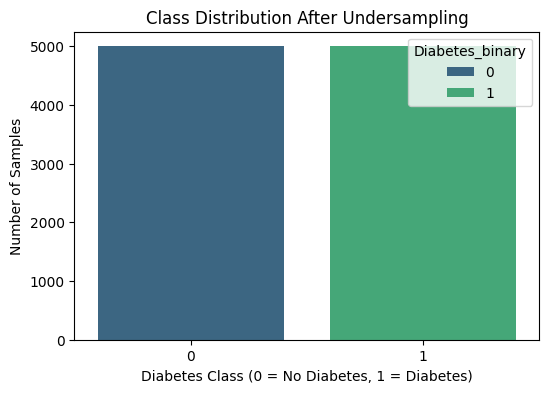

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
95413,1,1,1,-0.138886,0,0,0,1,1,1,...,0,2,-0.483194,-0.602516,0,1,-0.575079,1.095084,1.114489,1
248839,1,1,1,-0.828901,0,0,0,1,1,1,...,0,5,0.353858,-0.020075,0,0,0.473060,1.095084,0.194564,0
115962,1,1,1,-1.242909,0,0,0,1,0,1,...,0,2,-0.483194,-0.602516,0,1,-1.972597,1.095084,1.114489,0
83044,0,0,1,-0.690898,0,0,0,1,1,1,...,0,3,-0.483194,-0.602516,0,1,-1.623217,-0.842946,-1.185323,0
108231,0,0,1,-0.828901,1,1,0,1,1,1,...,0,2,-0.483194,-0.602516,1,1,0.473060,1.095084,-0.725361,0


In [ ]:
 # Plot class distribution after balancing
plt.figure(figsize=(6, 4))
sns.barplot(x=df_balanced[target_col].value_counts().index,
            y=df_balanced[target_col].value_counts().values,
            palette="viridis", hue = df_balanced[target_col].value_counts().index)
plt.xlabel("Diabetes Class (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Undersampling")
plt.show()

# Display the first few rows of the cleaned and processed dataset
df_balanced.head()

# **Data Split**

In [ ]:
# Define features (X) and target variable (y)
X = df_balanced.drop(columns=["Diabetes_binary"])
y = df_balanced["Diabetes_binary"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Model Definition**

In [ ]:
print("\nTraining and Evaluating Models...")

# Dictionary of models
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

#TODO: Tuning


# **Model Training and Evaluation**


In [ ]:
# Function to train and evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, model_name_prefix):
    results = []

    for name, model in models.items():
        print(f"Training {model_name_prefix} - {name}...")

        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        execution_time = time.time() - start_time

        auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

        results.append({
            "Model": f"{model_name_prefix} - {name}",
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC-ROC": auc,
            "Time (s)": execution_time
        })

    return results


# Evaluate models on Feature Importance → PCA data
results_feature_importance_pca = evaluate_models(X_train_pca, X_test_pca, y_train, y_test, "Feature Importance → PCA")

# Evaluate models on PCA → Feature Importance data
results_pca_feature_importance = evaluate_models(X_train_pca_all, X_test_pca_all, y_train, y_test, "PCA → Feature Importance")

# Display results
df_results = pd.DataFrame(results_feature_importance_pca + results_pca_feature_importance)
print("\nModel Evaluation Results:\n")
print(df_results)

In [ ]:
# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    execution_time = time.time() - start_time

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": roc_auc,
        "Time (s)": execution_time
    }

# Convert results into a DataFrame for visualization
results_df = pd.DataFrame(results).T

# **Results**

Model Performance Metrics:
                               Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432  


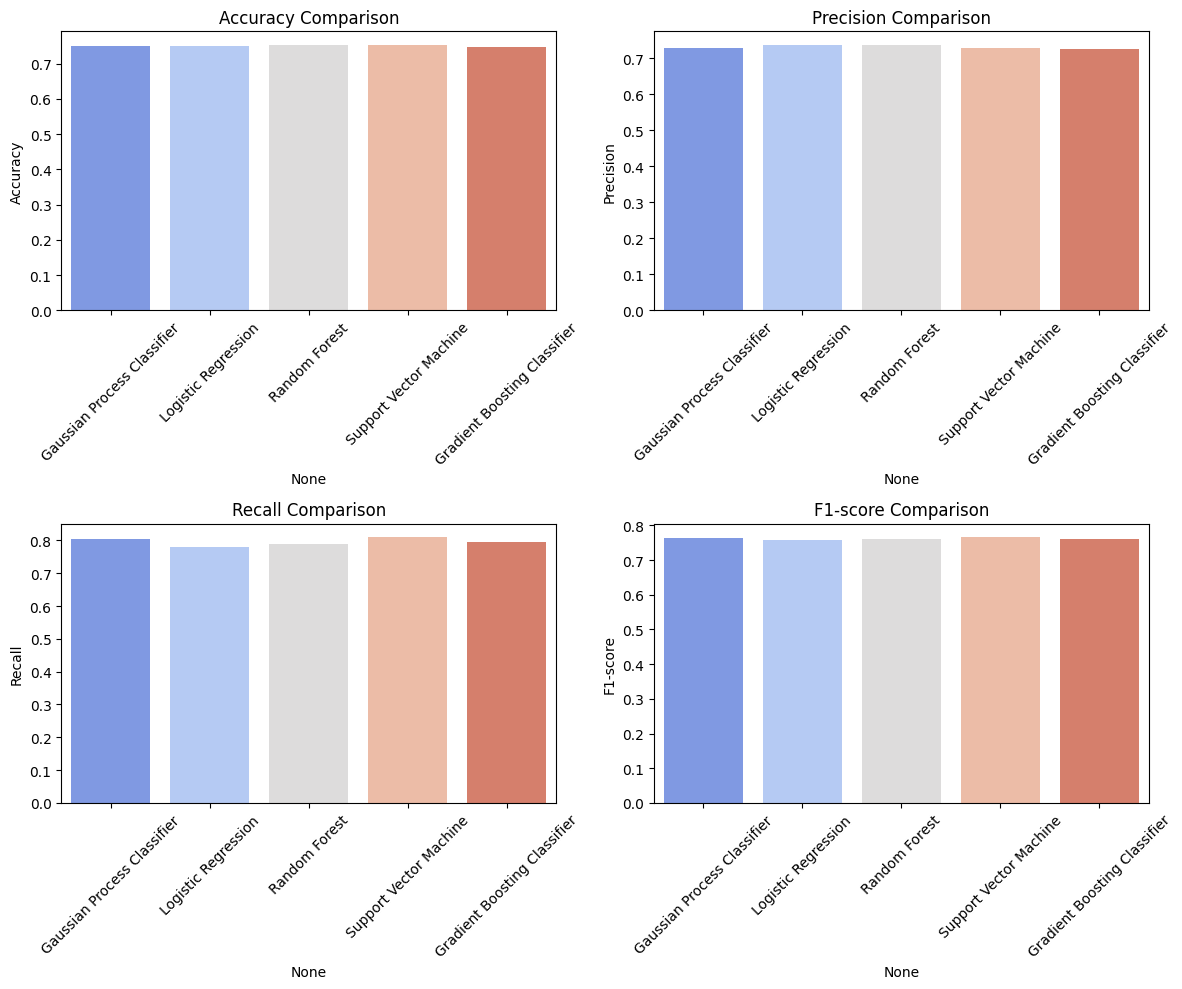


Classification Report for Gaussian Process Classifier:

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1000
           1       0.73      0.80      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1000
           1       0.74      0.78      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.74      0.79      0.76      1000

    accuracy                     

In [ ]:
# Display results
print("Model Performance Metrics:\n", results_df)

# ------------------------- VISUALIZATION -------------------------

# Plot model performance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], hue=results_df.index, palette="coolwarm", legend=False)
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(len(results_df.index)))
    axes[i].set_xticklabels(results_df.index, rotation=45)

plt.tight_layout()
plt.show()

# Display classification reports for each model
for name, model in models.items():
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, model.predict(X_test)))

# **Hyperparmeter Tuning on Select Models(Gausian Process Classifier and Logistic Regression)**

In [ ]:
# Define hyperparameter grids
param_grid_gpc = {
    'max_iter_predict': [50, 100, 200],
    'multi_class': ['one_vs_rest']
}

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Hyperparameter tuning for Gaussian Process Classifier
gpc = GaussianProcessClassifier()
gpc_search = RandomizedSearchCV(gpc, param_grid_gpc, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
gpc_search.fit(X_train, y_train)
best_gpc = gpc_search.best_estimator_
print("Best Parameters for Gaussian Process Classifier:", gpc_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr = LogisticRegression()
lr_search = RandomizedSearchCV(lr, param_grid_lr, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Parameters for Logistic Regression:", lr_search.best_params_)

# Evaluate tuned models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
    }

# Store results
results_tuned = {
    "Gaussian Process Classifier (Tuned)": evaluate_model(best_gpc, X_test, y_test),
    "Logistic Regression (Tuned)": evaluate_model(best_lr, X_test, y_test)
}

# Convert results to DataFrame
results_tuned_df = pd.DataFrame(results_tuned).T
print("Tuned Model Performance:\n", results_tuned_df)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Gaussian Process Classifier: {'multi_class': 'one_vs_rest', 'max_iter_predict': 50}
Best Parameters for Logistic Regression: {'solver': 'saga', 'C': 0.1}
Tuned Model Performance:
                                      Accuracy  Precision  Recall  F1-score  \
Gaussian Process Classifier (Tuned)    0.7515   0.728015   0.803  0.763671   
Logistic Regression (Tuned)            0.7495   0.736493   0.777  0.756204   

                                      ROC-AUC  
Gaussian Process Classifier (Tuned)  0.799165  
Logistic Regression (Tuned)          0.819067  


# **Post-Tuning Results**

In [ ]:
print (results_df, "\n\n",results_tuned_df)

                              Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432   

                                      Accuracy  Precision  Recall  F1-score  \
Gaussian Process Classifier (Tuned)    0.7515   0.728015   0.803  0.763671   
Logistic Regression (Tuned)            0.7495   0.736493   0.777  0.756204   

                 